In [1]:
# ## Simulation parameters
exp_name = 'exp-FINAL'
eps = 0.10
eps_str = '0_1'

run_idx_length = 1_000
N_val = 1_000
runs = 50

In [3]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial']
%config InlineBackend.figure_formats = ['svg']

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import itertools
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import metrics
import itertools

import joblib
from joblib import Parallel, delayed

In [5]:
from OPE_utils_new import (
    format_data_tensor,
    policy_eval_analytic_finite,
    OPE_IS_h,
    compute_behavior_policy_h,
)

In [6]:
def policy_eval_helper(π):
    V_H = policy_eval_analytic_finite(P.transpose((1,0,2)), R, π, gamma, H)
    Q_H = [(R + gamma * P.transpose((1,0,2)) @ V_H[h]) for h in range(1,H)] + [R]
    J = isd @ V_H[0]
    # Check recursive relationships
    assert len(Q_H) == H
    assert len(V_H) == H
    assert np.all(Q_H[-1] == R)
    assert np.all(np.sum(π * Q_H[-1], axis=1) == V_H[-1])
    assert np.all(R + gamma * P.transpose((1,0,2)) @ V_H[-1] == Q_H[-2])
    return V_H, Q_H, J

In [7]:
def iqm(x):
    return scipy.stats.trim_mean(x, proportiontocut=0.25, axis=None)

In [8]:
NSTEPS = H = 20   # max episode length in historical data # Horizon of the MDP
G_min = -1        # the minimum possible return
G_max =  1        # the maximum possible return
nS, nA = 1442, 8

PROB_DIAB = 0.2

In [9]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

In [10]:
# Precomputed optimal policy
π_star = joblib.load('../data/π_star.joblib')

## Policies

In [11]:
# vaso unif, mv abx optimal
π_unif = (np.tile(π_star.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)

### Behavior policy

In [12]:
# vaso eps=0.5, mv abx optimal
π_beh = (np.tile(π_star.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)
π_beh[π_star == 1] = 1-eps
π_beh[π_beh == 0.5] = eps

In [13]:
V_H_beh, Q_H_beh, J_beh = policy_eval_helper(π_beh)
J_beh

0.25038354793851164

### Optimal policy

In [14]:
V_H_star, Q_H_star, J_star = policy_eval_helper(π_star)
J_star

0.40877179296760224

### flip action for x% states

In [15]:
def get_π_flip(pol_flip_seed, pol_flip_num):
    rng_flip = np.random.default_rng(pol_flip_seed)
    flip_states = rng_flip.choice(range(1440), pol_flip_num, replace=False)

    π_tmp = (np.tile(π_star.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)
    π_flip = π_tmp.copy()
    π_flip[π_tmp == 0.5] = 0
    π_flip[π_star == 1] = 1
    for s in flip_states:
        π_flip[s, π_tmp[s] == 0.5] = 1
        π_flip[s, π_star[s] == 1] = 0
    assert π_flip.sum(axis=1).mean() == 1
    return π_flip

In [16]:
πs_flip_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        π_flip = get_π_flip(flip_seed, flip_num)
        πs_flip_list.append(π_flip)

In [17]:
v_list = []
for π_eval in tqdm(πs_flip_list):
    _, _, J_eval = policy_eval_helper(π_eval)
    v_list.append(J_eval)

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.57it/s]


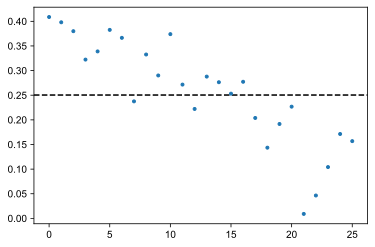

In [18]:
plt.plot(v_list, ls='none', marker='.')
plt.axhline(J_beh, c='k', ls='--', label='behavior', zorder=0)
plt.show()

## Load results

In [20]:
df_results_0 = pd.read_csv(f'./results/{exp_name}-1/vaso_eps_{eps_str}-observed.csv')

In [21]:
dfs_results_orig_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-1/vaso_eps_{eps_str}-{pol_name}-orig.csv')
        dfs_results_orig_list.append(df_results_)

In [22]:
dfs_results_annotEval_list = []
for flip_num in [0, 50, 100, 200, 300, 400]:
    for flip_seed in [0, 42, 123, 424242, 10000]:
        if flip_num == 0 and flip_seed != 0: continue
        pol_name = f'flip{flip_num}_seed{flip_seed}'
        df_results_ = pd.read_csv(f'./results/{exp_name}-2/vaso_eps_{eps_str}-{pol_name}-aug_step-annotEval.csv')
        dfs_results_annotEval_list.append(df_results_)

In [170]:
noise_list = list(np.arange(0.0, 1.1, 0.1).round(1))

In [171]:
dfs_results_annotEvalNoise_lists = []
for noise in noise_list:
    dfs_results_annotEvalNoise_list = []
    for flip_num in [0, 50, 100, 200, 300, 400]:
        for flip_seed in [0, 42, 123, 424242, 10000]:
            if flip_num == 0 and flip_seed != 0: continue
            pol_name = f'flip{flip_num}_seed{flip_seed}'
            df_results_ = pd.read_csv(f'./results/{exp_name}-3/vaso_eps_{eps_str}-{pol_name}-aug_step-annotEval-Noise_{noise}.csv')
            dfs_results_annotEvalNoise_list.append(df_results_)
    dfs_results_annotEvalNoise_lists.append(dfs_results_annotEvalNoise_list)

## Plots

In [172]:
exp_idx = 13
π_eval = πs_flip_list[exp_idx]
J_eval = v_list[exp_idx]
df_results_orig = dfs_results_orig_list[exp_idx]
df_results_annotEval = dfs_results_annotEval_list[exp_idx]

In [173]:
df_results_annotEval_Noise = [dfs[exp_idx] for dfs in dfs_results_annotEvalNoise_lists]

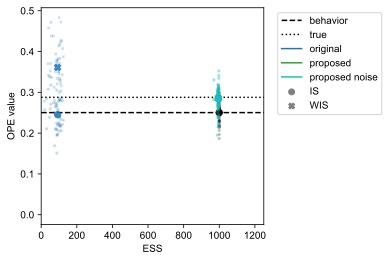

In [174]:
fig, ax = plt.subplots(figsize=(4,4))
plt.axhline(J_beh, c='k', ls='--', label='behavior', zorder=0)
plt.scatter(N_val, J_beh, marker='o', s=40, c='k', alpha=1)
plt.axhline(J_eval, c='k', ls=':', label='true', zorder=0)
plt.scatter([N_val]*runs, df_results_0['IS_value'], 
            marker='o', s=10, c='k', alpha=0.25, ec='none')

for df, name, color in [
    [df_results_orig, 'original', 'tab:blue'],
    [df_results_annotEval, 'proposed', 'tab:green'],
    [df_results_annotEval_Noise[-1], 'proposed noise', 'tab:cyan'],
]:
    plt.plot(0,0, c=color, label=name)
    plt.scatter(df['ESS1'], df['IS_value'], marker='o', s=10, c=color, alpha=0.25, ec='none')
    plt.scatter(iqm(df['ESS1']), iqm(df['IS_value']), marker='o', s=40, c=color, alpha=0.8)
    plt.scatter(df['ESS1'], df['WIS_value'], marker='X', s=10, c=color, alpha=0.25, ec='none')
    plt.scatter(iqm(df['ESS1']), iqm(df['WIS_value']), marker='X', s=40, c=color, alpha=0.8)

plt.scatter(-100,0, c='gray', marker='o', label='IS')
plt.scatter(-100,0, c='gray', marker='X', label='WIS')
plt.xlabel('ESS')
plt.ylabel('OPE value')
# plt.ylim(0.1, 0.7)
plt.xlim(0, N_val*1.25)
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

## Metrics

In [175]:
def rmse(y1, y2):
    return np.sqrt(np.mean(np.square(y1-y2)))

In [176]:
def compute_confmat(J_eval, v_est_list):
    confmat = np.zeros((2,2))
    confmat[int(J_eval >= J_beh), 0] += (v_est_list < df_results_0['IS_value'].iloc[:len(v_est_list)]).sum()
    confmat[int(J_eval >= J_beh), 1] += (v_est_list >= df_results_0['IS_value'].iloc[:len(v_est_list)]).sum()
    return confmat

In [275]:
def compute_confmat_batch(v_list, v_est_list, v_beh):
    confmat = np.zeros((2,2))
    for J_eval, v_est in zip(v_list, v_est_list):
        confmat[int(J_eval >= J_beh), 0] += (v_est < v_beh).sum()
        confmat[int(J_eval >= J_beh), 1] += (v_est >= v_beh).sum()
    return confmat

In [177]:
orig_v_IS = []
orig_v_WIS = []
orig_v_ESS = []
for π_eval, df_results_ in zip(πs_flip_list, dfs_results_orig_list):
    orig_v_IS.append(df_results_['IS_value'])
    orig_v_WIS.append(df_results_['WIS_value'])
    orig_v_ESS.append(df_results_['ESS1'])

In [178]:
annotEval_v_IS = []
annotEval_v_WIS = []
annotEval_v_ESS = []
for π_eval, df_results_ in zip(πs_flip_list, dfs_results_annotEval_list):
    annotEval_v_IS.append(df_results_['IS_value'])
    annotEval_v_WIS.append(df_results_['WIS_value'])
    annotEval_v_ESS.append(df_results_['ESS1'])

In [179]:
orig_rmse_value = np.mean([rmse(l,v) for v,l in zip(v_list+v_list, orig_v_IS+orig_v_WIS)])
orig_spearman_corr = np.mean([scipy.stats.spearmanr(v_list+v_list, v_π_est_list).correlation for v_π_est_list in np.array(orig_v_IS+orig_v_WIS).T])

In [180]:
oracle_rmse_value = np.mean([rmse(l,v) for v,l in zip(v_list+v_list, annotEval_v_IS+annotEval_v_WIS)])
oracle_spearman_corr = np.mean([scipy.stats.spearmanr(v_list+v_list, v_π_est_list).correlation for v_π_est_list in np.array(annotEval_v_IS+annotEval_v_WIS).T])

In [277]:
all_results = []
for noise, df_results_lists in zip(noise_list, dfs_results_annotEvalNoise_lists):
    print('===', 'Noise', noise)
    v_IS = []
    v_WIS = []
    v_ESS = []
    for π_eval, df_results_ in zip(πs_flip_list, df_results_lists):
        v_IS.append(df_results_['IS_value'])
        v_WIS.append(df_results_['WIS_value'])
        v_ESS.append(df_results_['ESS1'])
    print('ESS:', np.mean(v_ESS), np.array(v_ESS).mean(axis=0).std())
    
    v_est_list = v_IS + v_WIS
    rmse_value = [rmse(l, np.array(v_list+v_list)) for l in np.array(v_est_list).T]
    print('RMSE: {:.3f}±{:.3f}'.format(np.mean(rmse_value).round(3), np.std(rmse_value).round(3)))
    
    spearman_corr = [scipy.stats.spearmanr(l, np.array(v_list+v_list)).correlation for l in np.array(v_est_list).T]
    print('Spearman: {:.3f}±{:.3f}'.format(np.mean(spearman_corr).round(3), np.std(spearman_corr).round(3)))
    
    confmats_ = [compute_confmat_batch(v_list+v_list, l, vb) for l,vb in zip(np.array(v_est_list).T, df_results_0['IS_value'])]
    confmat_sum = sum(confmats_)
    (accuracy, fpr, fnr) = (
        [(cm[0,0]+cm[1,1])/np.sum(cm) for cm in confmats_],
        [cm[0,1]/(cm[0,0]+cm[0,1]) for cm in confmats_], 
        [cm[1,0]/(cm[1,0]+cm[1,1]) for cm in confmats_],
    )
    print('Accuracy: {:.1%}±{:.1%} \t FPR: {:.1%}±{:.1%} \t FNR: {:.1%}±{:.1%}'.format(
        np.mean(accuracy), np.std(accuracy), 
        np.mean(fpr), np.std(fpr), 
        np.mean(fnr), np.std(fnr), 
    ))
    display(pd.DataFrame(
        (confmat_sum).astype(int), 
        index=['$$v(\pi_e) < v(\pi_b)$$', '$$v(\pi_e) \geq v(\pi_b)$$'],
        columns=['$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$', '$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$'],
    ).rename_axis(index='True Ranking', columns=f'{name} Predicted Ranking')\
            .style.background_gradient(cmap='Blues', vmin=0, vmax=1500))
    
    all_results.append({
        'spearman': spearman_corr,
        'rmse': rmse_value,
        'accuracy': accuracy,
        'fpr': fpr,
        'fnr': fnr
    })

=== Noise 0.0
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.013±0.005
Spearman: 0.995±0.003
Accuracy: 95.7%±3.1% 	 FPR: 4.5%±6.9% 	 FNR: 4.2%±5.3%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1050,50
$$v(\pi_e) \geq v(\pi_b)$$,63,1437


=== Noise 0.1
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.013±0.005
Spearman: 0.995±0.003
Accuracy: 95.7%±3.5% 	 FPR: 4.4%±7.5% 	 FNR: 4.3%±5.7%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1052,48
$$v(\pi_e) \geq v(\pi_b)$$,65,1435


=== Noise 0.2
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.014±0.005
Spearman: 0.994±0.002
Accuracy: 95.3%±4.1% 	 FPR: 4.4%±7.9% 	 FNR: 4.9%±6.8%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1052,48
$$v(\pi_e) \geq v(\pi_b)$$,73,1427


=== Noise 0.3
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.015±0.005
Spearman: 0.994±0.002
Accuracy: 95.2%±4.5% 	 FPR: 4.7%±8.1% 	 FNR: 4.9%±7.5%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1048,52
$$v(\pi_e) \geq v(\pi_b)$$,74,1426


=== Noise 0.4
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.016±0.006
Spearman: 0.992±0.003
Accuracy: 94.9%±4.6% 	 FPR: 4.5%±8.2% 	 FNR: 5.5%±8.0%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1050,50
$$v(\pi_e) \geq v(\pi_b)$$,82,1418


=== Noise 0.5
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.018±0.006
Spearman: 0.991±0.004
Accuracy: 94.8%±4.8% 	 FPR: 4.5%±8.2% 	 FNR: 5.7%±8.3%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1050,50
$$v(\pi_e) \geq v(\pi_b)$$,85,1415


=== Noise 0.6
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.020±0.007
Spearman: 0.988±0.005
Accuracy: 94.2%±5.1% 	 FPR: 4.9%±8.8% 	 FNR: 6.5%±8.9%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1046,54
$$v(\pi_e) \geq v(\pi_b)$$,98,1402


=== Noise 0.7
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.022±0.008
Spearman: 0.986±0.006
Accuracy: 93.5%±5.4% 	 FPR: 5.2%±9.3% 	 FNR: 7.5%±9.8%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1043,57
$$v(\pi_e) \geq v(\pi_b)$$,112,1388


=== Noise 0.8
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.024±0.008
Spearman: 0.983±0.008
Accuracy: 92.9%±5.7% 	 FPR: 5.7%±10.0% 	 FNR: 8.1%±10.3%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1037,63
$$v(\pi_e) \geq v(\pi_b)$$,122,1378


=== Noise 0.9
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.027±0.009
Spearman: 0.980±0.009
Accuracy: 92.4%±5.7% 	 FPR: 6.5%±10.6% 	 FNR: 8.3%±10.5%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1028,72
$$v(\pi_e) \geq v(\pi_b)$$,125,1375


=== Noise 1.0
ESS: 993.9926736346977 3.030694969543688
RMSE: 0.029±0.010
Spearman: 0.977±0.012
Accuracy: 91.9%±5.6% 	 FPR: 6.7%±10.5% 	 FNR: 9.1%±10.6%


proposed noise Predicted Ranking,$$\hat{v}(\pi_e) < \hat{v}(\pi_b)$$,$$\hat{v}(\pi_e) \geq \hat{v}(\pi_b)$$
True Ranking,,
$$v(\pi_e) < v(\pi_b)$$,1026,74
$$v(\pi_e) \geq v(\pi_b)$$,136,1364


In [280]:
df_all_results = pd.DataFrame(all_results, index=noise_list)
df_all_results.index.name = 'noise'

In [292]:
df_all_results_median = df_all_results.applymap(np.median)
df_all_results_mean = df_all_results.applymap(np.mean)
df_all_results_std = df_all_results.applymap(np.std)

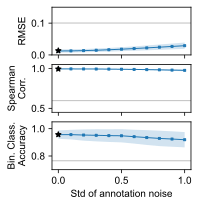

In [ ]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(2.5,3))
df_all_results_mean['rmse'].plot(ls='-', lw=1, marker='s', ms=2, c='tab:blue', ax=ax[0])
df_all_results_mean['spearman'].plot(ls='-', lw=1, marker='s', ms=2, c='tab:blue', ax=ax[1])
df_all_results_mean['accuracy'].plot(ls='-', lw=1, marker='s', ms=2, c='tab:blue', ax=ax[2])
ax[0].fill_between(noise_list, 
                   df_all_results_mean['rmse']-df_all_results_std['rmse'], 
                   df_all_results_mean['rmse']+df_all_results_std['rmse'], fc='tab:blue', alpha=0.2,
                  )
ax[1].fill_between(noise_list, 
                   df_all_results_mean['spearman']-df_all_results_std['spearman'], 
                   df_all_results_mean['spearman']+df_all_results_std['spearman'], fc='tab:blue', alpha=0.2,
                  )
ax[2].fill_between(noise_list, 
                   df_all_results_mean['accuracy']-df_all_results_std['accuracy'], 
                   df_all_results_mean['accuracy']+df_all_results_std['accuracy'], fc='tab:blue', alpha=0.2,
                  )
ax[0].plot(0, oracle_rmse_value, marker='*', c='k')
ax[1].plot(0, oracle_spearman_corr, marker='*', c='k')
ax[2].plot(0, 0.957, marker='*', c='k')
ax[0].axhline(orig_rmse_value, c='gray', ls=(0,(0.5,0.5)), lw=1)
ax[1].axhline(orig_spearman_corr, c='gray', ls=(0,(0.5,0.5)), lw=1)
ax[2].axhline(0.765, c='gray', ls=(0,(0.5,0.5)), lw=1)
ax[0].set_ylabel('RMSE')
ax[1].set_ylabel('Spearman\nCorr.')
ax[2].set_ylabel('Bin. Class.\nAccuracy')
ax[0].set_ylim(0, 0.15)
ax[1].set_ylim(0.45, 1.05)
ax[2].set_ylim(0.7, 1.05)
plt.xlabel('Std of annotation noise')
fig.align_labels()
# plt.figlegend(
#     [matplotlib.lines.Line2D([], [], c='gray', ls=':'), 
#      matplotlib.lines.Line2D([], [], c='k', marker='*', linestyle='none'),
#      matplotlib.lines.Line2D([], [], c='tab:blue'), 
#      ],
#     ['baseline', 'ideal setting', 'proposed', ],
#     loc='center', bbox_to_anchor=(0.5,1.0),
#     ncol=2, handlelength=1.333, handletextpad=0.6, columnspacing=1,
# )
plt.savefig('fig/annotation_noisy.pdf', bbox_inches='tight')
plt.show()